In [140]:
pip install inequalipy

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [141]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import inequalipy as ineq
import math
from statistics import mean 

In [142]:
std_df = pd.read_csv('/tmp/data/standard_neighborhood_df.csv')

In [143]:
duplicate_rows = np.where(std_df.duplicated(subset=['City Name', 'Population', 'Households',
       'Neighborhood Size', '% Black', '% Hispanic', '% >25 College Degree',
       'Avg household income', '% Broadband Access', '% > 100MB Access',
       'Devices per capita']))[0]
duplicate_rows

array([  98,  432,  511,  513,  514,  516,  517,  518,  519,  520,  521,
        522,  523,  524,  525,  526,  527,  528,  529,  530,  531,  615,
        616,  736,  805,  812,  827,  839,  849,  855,  857,  859,  902,
       1118, 1126, 1128, 1130, 1134, 1296, 1730])

In [144]:
std_df_no_duplicates = std_df.drop(duplicate_rows)

In [145]:
std_df_no_duplicates = std_df_no_duplicates.dropna()

In [146]:
def theil_index(city_name):
    city_pop = std_df_no_duplicates.loc[std_df_no_duplicates['City Name'] == city_name]['Population'].sum()
    pop_share = city_pop / std_df_no_duplicates["Population"].sum()
    
    city_avg_broadband = std_df_no_duplicates.loc[std_df_no_duplicates['City Name'] == city_name]["% Broadband Access"].mean()
    broadband_quotient = city_avg_broadband / std_df_no_duplicates["% Broadband Access"].mean()
    
    log_quotient = np.log(broadband_quotient)
    
    theil = pop_share * broadband_quotient * log_quotient
    
    return theil

In [147]:
theil_vals = []
for i in std_df_no_duplicates["City Name"].unique():
    theil_vals.append(theil_index(i))
    
theil_df = pd.DataFrame({'City' : std_df_no_duplicates["City Name"].unique(), "Theil Index" : theil_vals})
theil_df['Theil rank'] = theil_df['Theil Index'].rank(ascending=False)
theil_df = theil_df.sort_values(by=['Theil rank'])

In [148]:
# theil_df = theil_df.sort_values(by=['Theil Index'])

In [149]:
# theil_df.reset_index()
theil_df

,City,Theil Index,Theil rank
3,los-angeles,0.014101,1.0
10,san-jose,0.008145,2.0
11,san-diego,0.006831,3.0
16,san-francisco,0.004544,4.0
4,seattle,0.004498,5.0
7,portland,0.004020,6.0
6,austin,0.003806,7.0
14,denver,0.002720,8.0
12,boston,0.001694,9.0
0,phoenix,0.000632,10.0


In [150]:
# theil_df.iloc[0]

In [151]:
def atkinson_index(df, beta):
    cities = list(df['City Name'].unique())
    
    result = pd.DataFrame("", index = cities, columns =['Atkinson Index'])

    for city in cities:
        df_city = df[df['City Name'] == city]
        df_city_broadband = df_city['% Broadband Access']
        #df_city_population = df_city['Population']
        list_city_broadband = list(df_city_broadband)
        #array_city_population = np.array(df_city_population)
        result.loc[city, 'Atkinson Index'] = ineq.atkinson.index(list_city_broadband, np.absolute(beta))
    
    result['Atkinson Index'] = result['Atkinson Index'].apply(pd.to_numeric)
    result = result.sort_values('Atkinson Index', ascending=False)
    
    return result

In [152]:
# which city contributed most to observed inequality
atkinson_df = atkinson_index(std_df_no_duplicates, 10)
atkinson_df.reset_index(inplace=True)
atkinson_df = atkinson_df.rename(columns = {'index':'City'})
atkinson_df['Atkinson rank'] = atkinson_df['Atkinson Index'].rank(ascending=False)
atkinson_df = atkinson_df.sort_values(by=['Atkinson rank'])
atkinson_df

,City,Atkinson Index,Atkinson rank
0,seattle,0.195750,1.0
1,indianapolis,0.120119,2.0
2,baltimore,0.114208,3.0
3,dallas,0.101215,4.0
4,detroit,0.091052,5.0
5,washington-dc,0.085066,6.0
6,houston,0.078840,7.0
7,phoenix,0.064674,8.0
8,louisville,0.058399,9.0
9,san-francisco,0.048691,10.0


In [153]:
def palma_ratio(df):
    cities = list(df['City Name'].unique())
    
    result = pd.DataFrame("", index = cities, columns =['Palma Ratio'])
    
    for city in cities:
        df_city = df[df['City Name'] == city]
        df_city_broadband = df_city['% Broadband Access']
        array_city_broadband = np.array(df_city_broadband)
        palma_r = np.percentile(array_city_broadband, 90)/np.percentile(array_city_broadband, 40)
        result.loc[city, 'Palma Ratio'] = palma_r
    
    result['Palma Ratio'] = result['Palma Ratio'].apply(pd.to_numeric)
    result = result.sort_values('Palma Ratio', ascending=False)
    
    return result

In [154]:
# A high Palma ratio indicates a greater degree of inequality or unequal broadband distribution in a city
palma_df = palma_ratio(std_df_no_duplicates)
palma_df.reset_index(inplace=True)
palma_df = palma_df.rename(columns = {'index':'City'})
palma_df['Palma rank'] = palma_df['Palma Ratio'].rank(ascending=False)
palma_df = palma_df.sort_values(by=['Palma rank'])
palma_df

,City,Palma Ratio,Palma rank
0,baltimore,1.259507,1.0
1,detroit,1.210189,2.0
2,houston,1.204227,3.0
3,phoenix,1.202374,4.0
4,washington-dc,1.179223,5.0
5,dallas,1.176018,6.0
6,louisville,1.154286,7.0
7,austin,1.120976,8.0
8,indianapolis,1.114981,9.0
9,los-angeles,1.103925,10.0


In [155]:
def decile_ratio(df):
    cities = list(df['City Name'].unique())
    
    result = pd.DataFrame("", index = cities, columns =['Decile Ratio'])
    
    for city in cities:
        df_city = df[df['City Name'] == city]
        df_city_broadband = df_city['% Broadband Access']
        array_city_broadband = np.array(df_city_broadband)
        decile_r = np.percentile(array_city_broadband, 90)/np.percentile(array_city_broadband, 10)
        result.loc[city, 'Decile Ratio'] = decile_r
    
    result['Decile Ratio'] = result['Decile Ratio'].apply(pd.to_numeric)
    result = result.sort_values('Decile Ratio', ascending=False)
    
    return result

In [156]:
# A high Decile ratio indicates a greater degree of inequality or unequal broadband distribution in a city
decile_df = decile_ratio(std_df_no_duplicates)
decile_df.reset_index(inplace=True)
decile_df = decile_df.rename(columns = {'index':'City'})
decile_df['Decile rank'] = decile_df['Decile Ratio'].rank(ascending=False)
decile_df = decile_df.sort_values(by=['Decile rank'])
decile_df

,City,Decile Ratio,Decile rank
0,baltimore,1.546408,1.0
1,dallas,1.461930,2.0
2,detroit,1.402240,3.0
3,washington-dc,1.399631,4.0
4,houston,1.393458,5.0
5,phoenix,1.360162,6.0
6,louisville,1.332063,7.0
7,indianapolis,1.279284,8.0
8,los-angeles,1.255301,9.0
9,austin,1.209779,10.0


In [157]:
def gini(list_of_values):
    sorted_list = sorted(list_of_values)
    height, area = 0, 0
    for value in sorted_list:
        height += value
        area += height - value / 2.
    fair_area = height * len(list_of_values) / 2.
    gini_index=(fair_area - area) / fair_area
    return gini_index

In [158]:
cities = std_df_no_duplicates['City Name'].unique()

ls = []
for city in cities:
    city_values = std_df_no_duplicates[std_df_no_duplicates['City Name']==city]['% Broadband Access']
    gini_value = gini(city_values)
    ls.append([city, gini_value])
    
gini_data = pd.DataFrame(ls, columns=['City', 'Gini']) 
gini_data.sort_values(by ='Gini', ascending = 0)

gini_data['Gini rank'] = gini_data['Gini'].rank(ascending=False)
gini_data = gini_data.sort_values(by=['Gini rank'])
gini_data

,City,Gini,Gini rank
5,baltimore,0.089235,1.0
1,dallas,0.080311,2.0
2,detroit,0.075162,3.0
13,washington-dc,0.071764,4.0
15,houston,0.071456,5.0
0,phoenix,0.067474,6.0
8,indianapolis,0.060423,7.0
9,louisville,0.059894,8.0
3,los-angeles,0.047017,9.0
6,austin,0.042541,10.0


In [159]:
def mean_log_dev(list_of_values):
    log_list = []
    mean_value = list_of_values.mean()
    log_mean = math.log(mean_value)
    for value in list_of_values:
        log_x = math.log(value)
        log_list.append(log_x)
    mean_log = mean(log_list)
    mean_log_dev = log_mean - mean_log
    return mean_log_dev

In [160]:
log_s = []
for city in cities:
    city_values = std_df_no_duplicates[std_df_no_duplicates['City Name']==city]['% Broadband Access']
    mean_log_dev_value = mean_log_dev(city_values)
    log_s.append([city, mean_log_dev_value])
    
mean_log_data = pd.DataFrame(log_s, columns=['City', 'Mean log deviation']) 
mean_log_data['Mean log deviation rank'] = mean_log_data['Mean log deviation'].rank(ascending=False)
mean_log_data = mean_log_data.sort_values(by=['Mean log deviation rank'])
mean_log_data

,City,Mean log deviation,Mean log deviation rank
5,baltimore,0.012341,1.0
1,dallas,0.010920,2.0
2,detroit,0.008899,3.0
13,washington-dc,0.008284,4.0
15,houston,0.007947,5.0
8,indianapolis,0.007255,6.0
0,phoenix,0.007045,7.0
9,louisville,0.005630,8.0
3,los-angeles,0.003610,9.0
4,seattle,0.003474,10.0


In [234]:
def iqr_broadband(city): 

    df_city = std_df_no_duplicates[std_df_no_duplicates['City Name'] == city]
    df_city_broadband = df_city['% Broadband Access']
    array_city_broadband = np.array(df_city_broadband)
    Q3 = np.quantile(array_city_broadband, 0.75) 
    Q1 = np.quantile(array_city_broadband, 0.25)
    iqr_results = Q3 - Q1
    
    return iqr_results

In [248]:
results_iqr = []

for city in std_df_no_duplicates['City Name'].unique():
    results_iqr.append(iqr_broadband(city))
    
iqr_broadband_df = pd.DataFrame({'City': std_df_no_duplicates['City Name'].unique(), "IQR Broadband" : results_iqr})
iqr_broadband_df["IQR rank"] = iqr_broadband_df["IQR Broadband"].rank(ascending=False)
iqr_broadband_df = iqr_broadband_df.sort_values(by=["IQR rank"])
iqr_broadband_df

,City,IQR Broadband,IQR rank
1,dallas,0.214285,1.0
5,baltimore,0.194025,2.0
13,washington-dc,0.184029,3.0
0,phoenix,0.157159,4.0
15,houston,0.154765,5.0
9,louisville,0.132357,6.0
2,detroit,0.126714,7.0
6,austin,0.117407,8.0
8,indianapolis,0.108892,9.0
3,los-angeles,0.105280,10.0


In [249]:
inequality_df = pd.merge(pd.merge(pd.merge(pd.merge(pd.merge(pd.merge(theil_df,atkinson_df,on='City'),palma_df,on='City'),decile_df,on='City'), gini_data,on='City'),mean_log_data,on='City'),iqr_broadband_df,on='City') 
inequality_df

,City,Theil Index,Theil rank,Atkinson Index,Atkinson rank,Palma Ratio,Palma rank,Decile Ratio,Decile rank,Gini,Gini rank,Mean log deviation,Mean log deviation rank,IQR Broadband,IQR rank
0,los-angeles,0.014101,1.0,0.040601,11.0,1.103925,10.0,1.255301,9.0,0.047017,9.0,0.003610,9.0,0.105280,10.0
1,san-jose,0.008145,2.0,0.007511,17.0,1.035117,17.0,1.081388,17.0,0.018661,17.0,0.000638,17.0,0.039700,17.0
2,san-diego,0.006831,3.0,0.019593,14.0,1.072229,11.0,1.164198,12.0,0.031624,13.0,0.001690,13.0,0.074024,11.0
3,san-francisco,0.004544,4.0,0.048691,10.0,1.049272,15.0,1.179276,11.0,0.036126,11.0,0.002778,11.0,0.063143,12.0
4,seattle,0.004498,5.0,0.195750,1.0,1.049250,16.0,1.131991,14.0,0.033089,12.0,0.003474,10.0,0.059625,14.0
5,portland,0.004020,6.0,0.019780,13.0,1.063033,14.0,1.158063,13.0,0.029275,14.0,0.001536,14.0,0.046000,16.0
6,austin,0.003806,7.0,0.027758,12.0,1.120976,8.0,1.209779,10.0,0.042541,10.0,0.002768,12.0,0.117407,8.0
7,denver,0.002720,8.0,0.011194,16.0,1.065641,13.0,1.130136,15.0,0.026120,16.0,0.001066,16.0,0.060631,13.0
8,boston,0.001694,9.0,0.013541,15.0,1.069398,12.0,1.126689,16.0,0.028500,15.0,0.001308,15.0,0.049333,15.0
9,phoenix,0.000632,10.0,0.064674,8.0,1.202374,4.0,1.360162,6.0,0.067474,6.0,0.007045,7.0,0.157159,4.0


In [250]:
inequality_df = inequality_df.drop(columns=['Theil Index', 'Atkinson Index',"Palma Ratio", "Decile Ratio","Gini", "Mean log deviation", "IQR Broadband" ])

In [251]:
inequality_df

,City,Theil rank,Atkinson rank,Palma rank,Decile rank,Gini rank,Mean log deviation rank,IQR rank
0,los-angeles,1.0,11.0,10.0,9.0,9.0,9.0,10.0
1,san-jose,2.0,17.0,17.0,17.0,17.0,17.0,17.0
2,san-diego,3.0,14.0,11.0,12.0,13.0,13.0,11.0
3,san-francisco,4.0,10.0,15.0,11.0,11.0,11.0,12.0
4,seattle,5.0,1.0,16.0,14.0,12.0,10.0,14.0
5,portland,6.0,13.0,14.0,13.0,14.0,14.0,16.0
6,austin,7.0,12.0,8.0,10.0,10.0,12.0,8.0
7,denver,8.0,16.0,13.0,15.0,16.0,16.0,13.0
8,boston,9.0,15.0,12.0,16.0,15.0,15.0,15.0
9,phoenix,10.0,8.0,4.0,6.0,6.0,7.0,4.0


In [252]:
inequality_df =  inequality_df.astype({'Theil rank' : "int", 'Atkinson rank' : "int" ,"Palma rank" : "int", "Decile rank" : "int","Gini rank" : "int", "Mean log deviation rank" : "int", "IQR rank" : "int" })


In [253]:
inequality_df = inequality_df.set_index('City').T

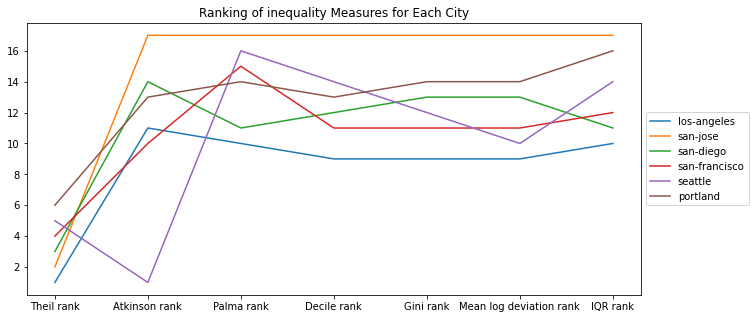

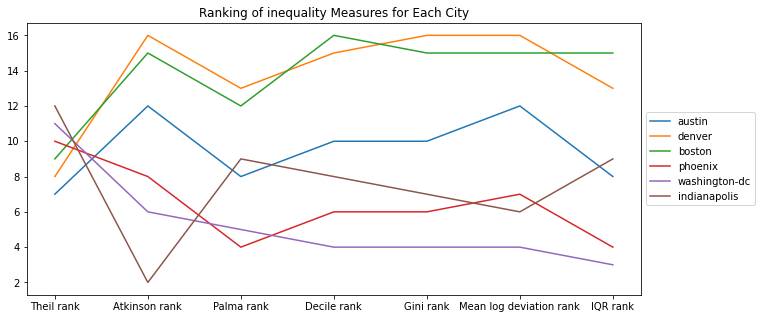

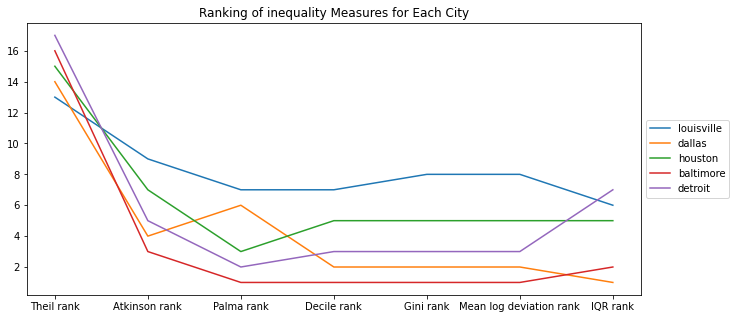

In [256]:
f = plt.figure(figsize=(11,5))

plt.title('Ranking of inequality Measures for Each City', color='black')
inequality_df.iloc[:,:6].plot(kind='line', ax=f.gca())
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()


f = plt.figure(figsize=(11,5))

plt.title('Ranking of inequality Measures for Each City', color='black')
inequality_df.iloc[:,6:12].plot(kind='line', ax=f.gca())
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()


f = plt.figure(figsize=(11,5))

plt.title('Ranking of inequality Measures for Each City', color='black')
inequality_df.iloc[:,12:19].plot(kind='line', ax=f.gca())
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()



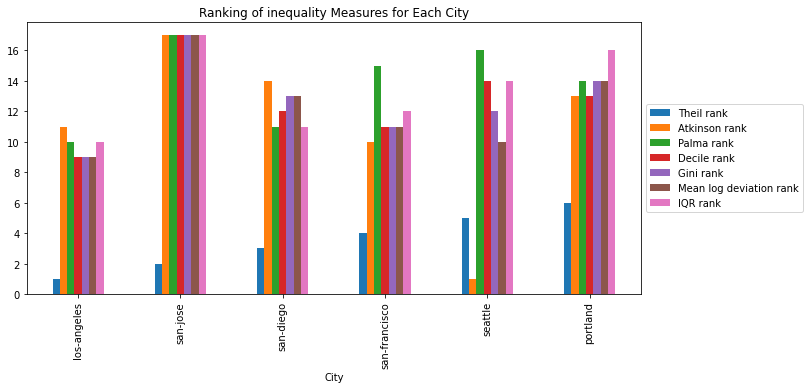

In [264]:
f = plt.figure(figsize=(11,5))

plt.title('Ranking of inequality Measures for Each City', color='black')
inequality_df.T.iloc[:6].plot(kind='bar', ax=f.gca())
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

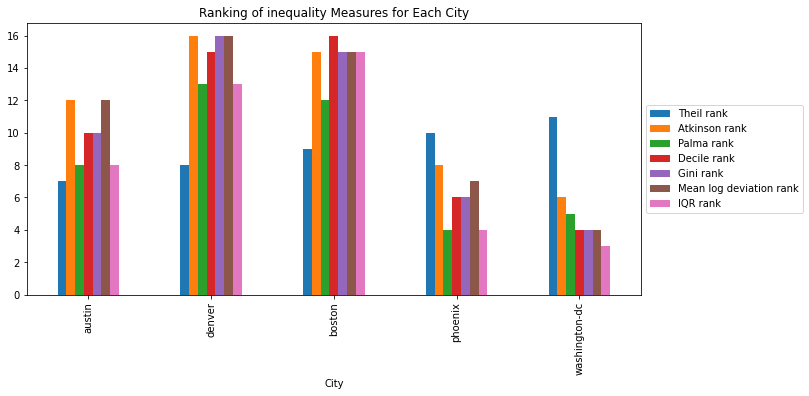

In [265]:
f = plt.figure(figsize=(11,5))

plt.title('Ranking of inequality Measures for Each City', color='black')
inequality_df.T.iloc[6:11].plot(kind='bar', ax=f.gca())
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

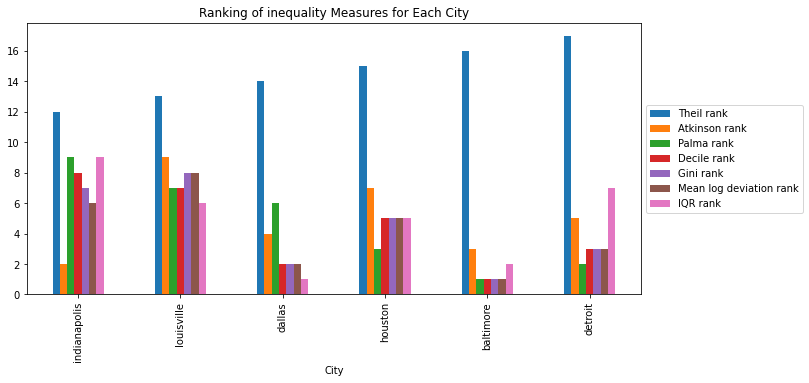

In [266]:
f = plt.figure(figsize=(11,5))

plt.title('Ranking of inequality Measures for Each City', color='black')
inequality_df.T.iloc[11:17].plot(kind='bar', ax=f.gca())
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

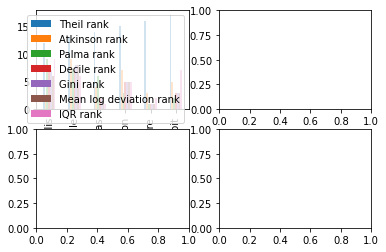

In [271]:
fig, axes = plt.subplots(nrows=2, ncols=2)
# fig.figsize
inequality_df.T.iloc[11:17].plot(kind='bar', ax=axes[0,0])
fig.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()